## Trend Events

In this tutorial we use `judgyprophet` to forecast a time series with a known/expected change in trend. This is called a `trend_event` and an example would be the following:

<AxesSubplot:>

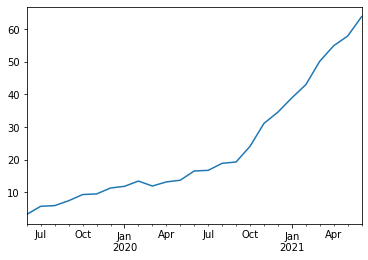

In [1]:
from judgyprophet.tutorials.resources import get_trend_event

example_data = get_trend_event()
example_data.plot.line()

We can see from the plot that there is an uptick in trend around September 2020.

#### Format the trend event expectation for JudgyProphet
Suppose we are in April 2020, and we have the prior knowledge that an event will occur in September. The expected change of the trend gradient will be an uptick of 6. We can encode this in `judgyprophet` as an expected trend event as follows:

In [2]:
trend_events = [
    {'name': "New market entry", 'index': '2020-09-01', 'm0': 6}
]

Each trend event is encoded as a dict with two required entries: the 'index' field, which is the index in the data when the event occurs. If this entry is fed into example_data.loc[], then it should return a single value. It follows the standard pandas indexing rules (for example, see here). The 'm0' field is the initial estimate by the business of what the impact of this event on the trend will be (e.g. in our case we estimate it will increase the trend by 6). It is fed into the model as an informative prior on the level event mean; which is then updated in a Bayesian way.

#### Forecasting with JudgyProphet before the event occurs
Now let's pretend we're still in April 2020, and see what `judgyprophet` would have forecasted:

In [3]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns

# Cutoff the data to January 2020
data_apr2020 = example_data.loc[:"2020-04-01"]

# Make the forecast with the business estimated level event
# We have no trend events, so just provide the empty list.
jp = JudgyProphet()
# Because the event is beyond the actuals, judgyprophet throws a warning.
#    This is just because the Bayesian model at the event has no actuals to learn from.
#    The event is still used in predictions.
jp.fit(
    data=data_apr2020,
    level_events=[],
    trend_events=trend_events,
    sigma_base_bias=1.,
    sigma_base_trend=1.,
    unspecified_changepoints=0,
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=12)

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.


Initial log joint probability = -17.6559
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       5      -2.70162    0.00625172   1.10466e-05           1           1        8   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Plotting the results:

<AxesSubplot:xlabel='ds', ylabel='value'>

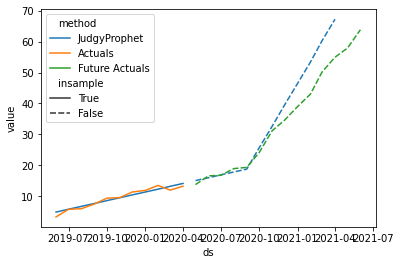

In [4]:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_apr2020.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc["2020-05-01":]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

#### Forecasting with JudgyProphet after the event occurs
We can see that with the business information, the forecast is better able to handle the sudden uptick in trend. After a while though, we can see that the business estimate of the trend is an overestimate. Let's see if the Bayesian updating can account for this. We now suppose we are re-forecasting the product in January 2021.

In [5]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns

# Cutoff the data to January 2020
data_jan2021 = example_data.loc[:"2021-01-01"]

# Make the forecast with the business estimated level event
# We have no trend events, so just provide the empty list.
jp = JudgyProphet()
# Because the event is beyond the actuals, judgyprophet throws a warning.
#    This is just because the Bayesian model at the event has no actuals to learn from.
#    The event is still used in predictions.
jp.fit(
    data=data_jan2021,
    level_events=[],
    trend_events=trend_events,
    unspecified_changepoints=0,
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=12)

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.
INFO:judgyprophet.judgyprophet:Adding trend event New market entry to model. Event index: 2020-09-01, training data start index: 2019-06-01 00:00:00, training data end index: 2021-01-01 00:00:00. Initial gradient: 6. Damping: None.


Initial log joint probability = -18.4007
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       7      -1.64341   1.13818e-05   8.53133e-05           1           1       10   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<AxesSubplot:xlabel='ds', ylabel='value'>

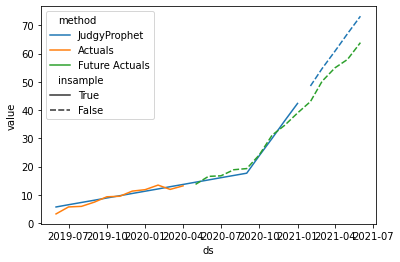

In [6]:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[predictions.index <= "2021-06-01", ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_apr2020.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc["2020-05-01":]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

Although the forecast is still a slight overestimate, the Bayesian updating has downgraded the initial estimate somewhat.

### Trend event reducing the historic trend
A trend event can also reduce the previous trend. A common real world examples for this case are a competitor entering the market and thus over time reducing your products market share.

<AxesSubplot:>

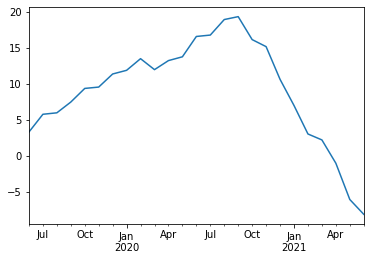

In [7]:
example_data = get_trend_event(uptake=False)
example_data.plot.line()

#### Format the trend event expectation for JudgyProphet
In this case, we simply add a minus to the expected trend impact:

In [8]:
trend_events = [
    {'name': "New market entry", 'index': '2020-09-01', 'm0': -6}
]

#### Forecasting with JudgyProphet before the event occurs
Again, we're still in April 2020, and see what `judgyprophet` would have forecasted:

In [9]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns

# Cutoff the data to January 2020
data_apr2020 = example_data.loc[:"2020-04-01"]

# Make the forecast with the business estimated level event
# We have no trend events, so just provide the empty list.
jp = JudgyProphet()
# Because the event is beyond the actuals, judgyprophet throws a warning.
#    This is just because the Bayesian model at the event has no actuals to learn from.
#    The event is still used in predictions.
jp.fit(
    data=data_apr2020,
    level_events=[],
    trend_events=trend_events,
    sigma_base_bias=1.,
    sigma_base_trend=1.,
    unspecified_changepoints=0,
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=12)

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.


Initial log joint probability = -3.20978
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       7      -2.70162   5.03247e-05   6.65978e-05           1           1        9   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Plotting the results:

<AxesSubplot:xlabel='ds', ylabel='value'>

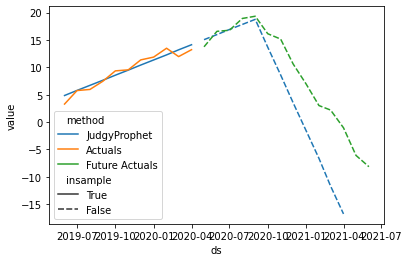

In [10]:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_apr2020.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc["2020-05-01":]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

#### Forecasting with JudgyProphet after the event occurs
And after the event, we again learn from the additional data points:

In [11]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns

# Cutoff the data to January 2020
data_jan2021 = example_data.loc[:"2021-01-01"]

# Make the forecast with the business estimated level event
# We have no trend events, so just provide the empty list.
jp = JudgyProphet()
# Because the event is beyond the actuals, judgyprophet throws a warning.
#    This is just because the Bayesian model at the event has no actuals to learn from.
#    The event is still used in predictions.
jp.fit(
    data=data_jan2021,
    level_events=[],
    trend_events=trend_events,
    unspecified_changepoints=0,
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=12)

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.
INFO:judgyprophet.judgyprophet:Adding trend event New market entry to model. Event index: 2020-09-01, training data start index: 2019-06-01 00:00:00, training data end index: 2021-01-01 00:00:00. Initial gradient: -6. Damping: None.


Initial log joint probability = -28.0997
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       6      -7.46664   0.000740991   0.000446113           1           1        9   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<AxesSubplot:xlabel='ds', ylabel='value'>

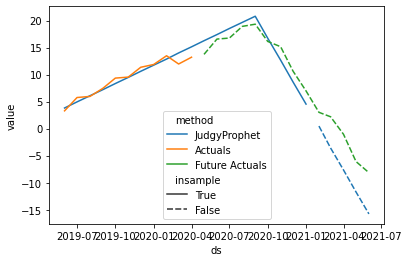

In [12]:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[predictions.index <= "2021-06-01", ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_apr2020.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc["2020-05-01":]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

### Damping

In real world examples, we often observe that the initial trend after the event changes over time. A good example is the total sales of a product if this product is released to an additional new market. In this scenario, there is usually a period of strong uptake initially, followed by a slowing of uptake as the market saturates. We model this in `judgyprophet` by using damping. The damping model is a linear trend with damping, which is the same as that used in one of the most popular exponential smoothing methods: Holt's linear damped trend (see [here](https://otexts.com/fpp3/holt.html#damped-trend-methods)).

Unlike the trend and level parameters, the damping is set by the user, and is not learnt during fitting. This is because we found learning using Bayesian fitting to be inaccurate. If you are not sure what the damping term should be we recommend using cross-validation, or observing similar market launches. The damping term is usually between 0.8 and 1 (where 1 means no damping, i.e. a linear model), it is equivalent to the $\phi$ parameter in the description of Holt's linear damped trend.

Those who know Prophet will remember it modelled this using logistic curves. We found this was extremely sensitive to the choice of the capacity parameter $C$ (the population the new entrant would eventually reach). This is why we opted for the damped linear trend, which we found to be more flexible.

Let's look at a curve with damping:

2019-06-01    3.287609
2019-07-01    5.253766
2019-08-01    4.955497
2019-09-01    5.951812
2019-10-01    7.345102
Freq: MS, dtype: float64


<AxesSubplot:>

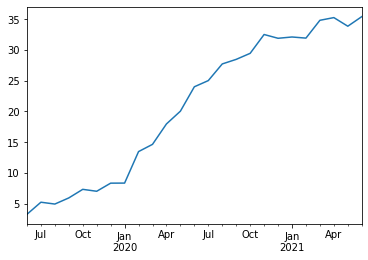

In [13]:
from judgyprophet.tutorials.resources import get_damped_trend_event

example_data = get_damped_trend_event()
print(example_data.head())
example_data.plot.line()

We can see there is an initial uptick in trend, followed by a plateauing effect as the market saturates.

#### Format the damped trend event expectation for JudgyProphet
We talk to the business and they assume the initial trend uptake is 5, with a damping parameter from analysing similar market entrants of .9. We encode this as a `trend_event` as follows, notice that we refer to the damping parameter as `gamma`:

In [14]:
trend_events = [
    {'name': "New saturating market entry", 'index': '2020-01-01', 'm0': 5, 'gamma': .85}
]

#### Forecasting with JudgyProphet before the event occurs

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.


Initial log joint probability = -4.75577
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       4      -2.08579     0.0190169   7.99064e-06           1           1        6   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<AxesSubplot:xlabel='ds', ylabel='value'>

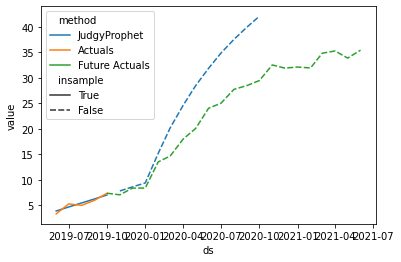

In [15]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns

# Cutoff the data to January 2020
data_oct2019 = example_data.loc[:"2019-10-01"]

# Make the forecast with the business estimated level event
# We have no trend events, so just provide the empty list.
jp = JudgyProphet()
# Because the event is beyond the actuals, judgyprophet throws a warning.
#    This is just because the Bayesian model at the event has no actuals to learn from.
#    The event is still used in predictions.
jp.fit(
    data=data_oct2019,
    level_events=[],
    trend_events=trend_events,
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=12)

# Plot the data:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_oct2019.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc["2019-10-01":]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

We can see the initial estimates are quite off this time. This is because the business overestimated the damping and the trend. Let's see what happens as we start to observe actuals.

#### Forecasting with JudgyProphet after the event occurs

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.
INFO:judgyprophet.judgyprophet:Adding trend event New saturating market entry to model. Event index: 2020-01-01, training data start index: 2019-06-01 00:00:00, training data end index: 2020-04-01 00:00:00. Initial gradient: 5. Damping: 0.85.


Initial log joint probability = -10.4473
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       9      -2.49061   8.76664e-05    0.00143778      0.9171      0.9171       11   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<AxesSubplot:xlabel='ds', ylabel='value'>

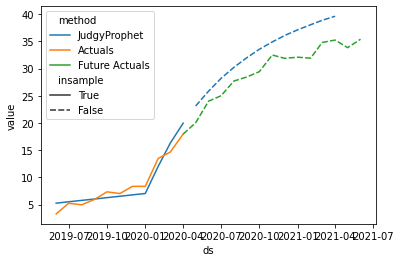

In [16]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns

# Cutoff the data to January 2020
cutoff = "2020-04-01"
data_cutoff = example_data.loc[:cutoff]

# Make the forecast with the business estimated level event
# We have no trend events, so just provide the empty list.
jp = JudgyProphet()
# Because the event is beyond the actuals, judgyprophet throws a warning.
#    This is just because the Bayesian model at the event has no actuals to learn from.
#    The event is still used in predictions.
jp.fit(
    data=data_cutoff,
    level_events=[],
    trend_events=trend_events,
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=12)

# Plot the data:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_cutoff.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc[cutoff:]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

While the trend is still a little overestimated, it is definitely improving. But is there anything we can do to improve the situation?

### Unspecified Changepoints

Like prophet, we enable the user to include unspecified changepoints into the forecast. Unexpected changepoints enables us to handle unexpected changes in the trend of level of the time series. This is done by setting the `unspecified_changepoints` parameter in the `fit` method of `JudgyProphet`. Unspecified changepoints are initially set to have no effect on the model, but if actuals are observed that deviate from the model, they will be 'turned on,' and change the model.

The arg `unspecified_changepoints` either takes an integer as input, which will intersperse the changepoints equally across time, or a list of indexes, which will place changepoints at exactly those time points. These changepoints are given a Laplace prior with a mean of 0, and a scale set by the arg `sigma_unspecified_changepoints`. The `sigma_unspecified_changepoints` affects the L1 penalty on the unspecified changepoints. Set `sigma` to be high (e.g. .5 or greater) and the unspecified changepoints will be very sensitive. Set it low (e.g. 0.05), and it will be insensitive.

Unlike prophet, setting these changepoints does not change the prediction. Only `level_events` and `trend_events` in the prediction horizon will affect the forecast. Let's see what affect these have on the previous damping example...

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.
INFO:judgyprophet.judgyprophet:Adding trend event New saturating market entry to model. Event index: 2020-01-01, training data start index: 2019-06-01 00:00:00, training data end index: 2020-04-01 00:00:00. Initial gradient: 5. Damping: 0.85.


Initial log joint probability = -85.6424
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      12      -2.55807    0.00253247       10.5928   0.0002553       0.001       57  LS failed, Hessian reset 
      19      -2.53784    0.00129929       12.9114       2.828      0.4174       69   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39      -2.49159   1.88991e-05       13.7481     0.05264           1      106   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      43      -2.49059   2.07785e-05        13.316   1.762e-06       0.001      150  LS failed, Hessian reset 
      49      -2.48998    7.5683e-06       12.3042   6.778e-07       0.001      193  LS failed, Hessian reset 
      59      -2.48991   3.40412e-07       12.2862      0.3482      0.3482      210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/kpxh622/github/judgyprophet/judgyprophet/utils.py:31: UserWarning: Unspecified changepoint with index 2020-01-01 00:00:00 also specified as a level or trend event. Removing this changepoint.
  warnings.warn(msg)


<AxesSubplot:xlabel='ds', ylabel='value'>

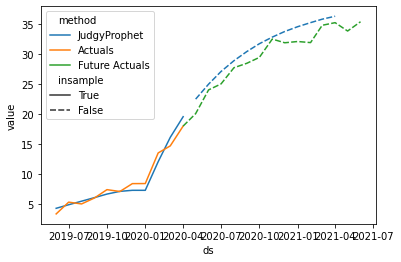

In [17]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns

# Cutoff the data to January 2020
cutoff = "2020-04-01"
data_cutoff = example_data.loc[:cutoff]

# Make the forecast with the business estimated level event
# We have no trend events, so just provide the empty list.
jp = JudgyProphet()
# Because the event is beyond the actuals, judgyprophet throws a warning.
#    This is just because the Bayesian model at the event has no actuals to learn from.
#    The event is still used in predictions.
jp.fit(
    data=data_cutoff,
    level_events=[],
    unspecified_changepoints=10,
    sigma_unspecified_changepoints=.2,
    trend_events=trend_events,
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=12)

# Plot the data:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_cutoff.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc[cutoff:]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

We can see in this case the unspecified changepoints have improved the model fit significantly. We recommend caution with unspecified changepoints though, they come with a cost, and when your time series is quite noisy they might be overreactive. In this case it is recommended to tune your `sigma_unspecified_changepoints` accordingly, or limit the amount of changepoints you use.